# Model implementation

Information Geometry Soft Clustering for Sport Analytics

Joaquin Garay

In [1]:
%load_ext autoreload
%autoreload 2

import os
import time
import tqdm
import numpy as np
import pandas as pd

import vis
import softclustering as sc

from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt
import socceraction.spadl as spadl


### Data Preparation

Concatenate actions of all games in one DataFrame.

In [2]:
datafolder = "data"
fifa2018h5 = os.path.join(datafolder, "spadl-fifa2018.h5")
games = pd.read_hdf(fifa2018h5, key="games")
with pd.HDFStore(fifa2018h5) as store:
    actions = []  #list of DataFrames
    for game in tqdm.tqdm(games.itertuples()):
        game_action = store[f"actions/game_{game.game_id}"]
        game_action = spadl.play_left_to_right(game_action, game.home_team_id)
        game_action["is_home"] = game_action["team_id"] == game.home_team_id
        actions.append(game_action)
    actions = pd.concat(actions)
    actions.drop("original_event_id", axis=1, inplace=True)
    actions = pd.merge(actions, spadl.config.actiontypes_df(), how="left")

64it [00:00, 180.88it/s]


In [3]:
def consolidate(actions):
    #actions.fillna(0, inplace=True)

    #Consolidate corner_short and corner_crossed
    corner_idx = actions.type_name.str.contains("corner")
    actions["type_name"] = actions["type_name"].mask(corner_idx, "corner")

    #Consolidate freekick_short, freekick_crossed, and shot_freekick
    freekick_idx = actions.type_name.str.contains("freekick")
    actions["type_name"] = actions["type_name"].mask(freekick_idx, "freekick")

    #Consolidate keeper_claim, keeper_punch, keeper_save, keeper_pick_up
    keeper_idx = actions.type_name.str.contains("keeper")
    actions["type_name"] = actions["type_name"].mask(keeper_idx, "keeper_action")

    actions["start_x"] = actions["start_x"].mask(actions.type_name == "shot_penalty", 94.5)
    actions["start_y"] = actions["start_y"].mask(actions.type_name == "shot_penalty", 34)

    return actions


actions = consolidate(actions)

In [4]:
#Actions of Team France matches.
len(actions[actions["team_id"] == 771])

6829

In [5]:
actions.groupby("type_name").size()

type_name
bad_touch         1547
clearance         2074
corner             558
cross             1305
dribble          52731
foul              1876
freekick          1272
goalkick           677
interception      1681
keeper_action      584
pass             56438
shot              1556
shot_penalty        68
tackle            1830
take_on           2109
throw_in          2178
dtype: int64

As suggested in SoccerMix, add noise on the starting and ending locations, but only on those actions that we can visually note a predefined pattern.
* *Add noise in both start and end locations*:
    * Cross
    * Shot
    * Keeper_action
* *Only on start locations*:
    * Clearance
    * Goal kick
* *Only on end locations*:
    * Corner
    * Freekick
    * Shot_penalty

In [6]:
def add_noise(actions):
    # Start locations
    start_list = ["cross", "shot", "keeper_action", "clearance", "goalkick"]
    mask = actions["type_name"].isin(start_list)
    noise = np.random.normal(0, 0.5, size=actions.loc[mask, ["start_x", "start_y"]].shape)
    actions.loc[mask, ["start_x", "start_y"]] += noise

    # End locations
    end_list = ["cross", "shot", "keeper_action", "corner", "freekick", "shot_penalty"]
    mask = actions["type_name"].isin(end_list)
    noise = np.random.normal(0, 0.5, size=actions.loc[mask, ["end_x", "end_y"]].shape)
    actions.loc[mask, ["end_x", "end_y"]] += noise

    return actions


actions = add_noise(actions)

In [7]:
# # display event locations with noise
# corrected_actions = ["cross", "shot", "keeper_action", "clearance", "goalkick","corner", "freekick", "shot_penalty"]
# for actiontype in corrected_actions:
#     actions[actions.type_name == actiontype].plot.scatter(
#         x="start_x",
#         y="start_y",
#         title = f"Start Location: {actiontype}",
#         figsize = (6,4)
#     )
#     plt.show()
#     actions[actions.type_name == actiontype].plot.scatter(
#         x="end_x",
#         y="end_y",
#         title = f"End Location: {actiontype}",
#         figsize = (6,4)
#     )
#     plt.show()

In [8]:
def remove_outliers(actions, verbose=False):
    X = actions[["start_x","start_y","end_x","end_y"]].to_numpy(dtype=float)
    inliers = LocalOutlierFactor(contamination="auto").fit_predict(X)
    if verbose:
        print(f"Remove {(inliers==-1).sum()} out of {X.shape[0]} datapoints.")
    return actions[inliers==1]

actions = remove_outliers(actions,True)

Remove 640 out of 128484 datapoints.


### Features

Compute the angle of the direction of the action with respect with the x-axis (pitch's length) a
$$\tan \theta = \frac{y_{end} - y_{start}}{x_{end} - x_{start}}$$

In [9]:
actions["angle"] = np.arctan2(actions.end_y - actions.start_y, actions.end_x - actions.start_x)
actions["cos_angle"] = np.cos(actions["angle"])
actions["sin_angle"] = np.sin(actions["angle"])
actions[["angle", "cos_angle", "sin_angle"]].describe()

,angle,cos_angle,sin_angle
count,127844.000000,127844.000000,127844.000000
mean,0.061681,0.317571,-0.005922
std,1.459133,0.676655,0.664273
min,-3.137941,-1.000000,-1.000000
25%,-0.969342,-0.169098,-0.647648
50%,0.000000,0.532483,0.000000
75%,1.064659,0.956027,0.624695
max,3.141593,1.000000,1.000000


### First run

Let's run a first toy implementation using throw-ins of team France.

In [10]:
mask = (actions["type_name"]=="pass") #& (actions["team_id"]==771)
loc_data = actions[mask][["start_x", "start_y"]]
dir_data = actions[mask][["cos_angle", "sin_angle"]]

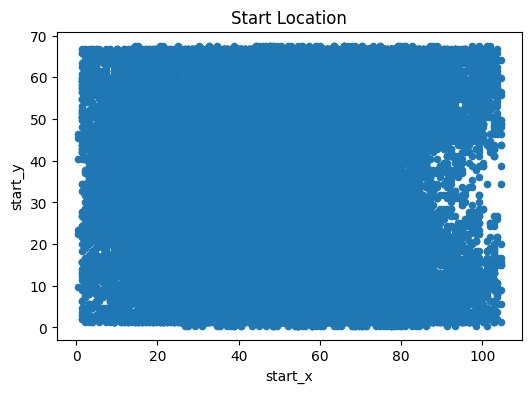

In [11]:
loc_data.plot.scatter(
        x="start_x",
        y="start_y",
        title = f"Start Location",
        figsize = (6,4)
    )
plt.show()

In [12]:
#Gaussian clusters
k_gauss = 4

gauss_clusters = [sc.MultivariateGaussian() for j in range(k_gauss)]

loc_em_model = sc.MixtureModel(gauss_clusters)
loc_bregman_model = sc.MixtureModel(gauss_clusters)

# Classic EM
start = time.time()
res_em = loc_em_model.fit_em_classic(loc_data, verbose=False)
t_em = time.time() - start

# Bregman EM
start = time.time()
res_bregman = loc_bregman_model.fit_em_bregman(loc_data, verbose=False)
t_bregman = time.time() - start

# Results
print(f"Final log-likelihoods:\nEM: {res_em[-1]:.4f}\nBregman: {res_bregman[-1]:.4f}")
print(f"Timings:\nEM: {t_em:.4f}s\nBregman: {t_bregman:.4f}s")

Final log-likelihoods:
EM: -490940.9416
Bregman: -490940.9416
Timings:
EM: 5.2648s
Bregman: 4.5141s


In [13]:
for model in [loc_em_model, loc_bregman_model]:
    print(f"{model}\n")

MixtureModel(n_clusters=4)
  ├─ (0) w=0.396  MultivariateGaussian(d=2, mean=[52.943 20.318], cov=[[403.151 -33.344], [-33.344  89.531]])
  ├─ (1) w=0.075  MultivariateGaussian(d=2, mean=[17.432 33.775], cov=[[66.082 -2.985], [ -2.985 231.479]])
  ├─ (2) w=0.452  MultivariateGaussian(d=2, mean=[53.985 51.605], cov=[[407.834  28.994], [28.994 96.454]])
  └─ (3) w=0.077  MultivariateGaussian(d=2, mean=[57.204  3.196], cov=[[414.951  -1.361], [-1.361  2.016]])

MixtureModel(n_clusters=4)
  ├─ (0) w=0.396  MultivariateGaussian(d=2, mean=[52.943 20.318], cov=[[403.151 -33.344], [-33.344  89.531]])
  ├─ (1) w=0.075  MultivariateGaussian(d=2, mean=[17.432 33.775], cov=[[66.082 -2.985], [ -2.985 231.479]])
  ├─ (2) w=0.452  MultivariateGaussian(d=2, mean=[53.985 51.605], cov=[[407.834  28.994], [28.994 96.454]])
  └─ (3) w=0.077  MultivariateGaussian(d=2, mean=[57.204  3.196], cov=[[414.951  -1.361], [-1.361  2.016]])



In [14]:
loc_em_model.get_posteriors(loc_data)

array([[5.79958419e-001, 5.89325546e-005, 4.19982648e-001,
        1.48594539e-105],
       [5.84127772e-001, 2.28834682e-003, 4.13583881e-001,
        1.86398981e-105],
       [9.86024229e-001, 2.21517887e-003, 1.17605924e-002,
        2.33681173e-037],
       ...,
       [9.99945946e-001, 1.45988996e-021, 5.23221295e-005,
        1.73167900e-006],
       [9.90546107e-001, 3.35354442e-019, 9.45389290e-003,
        8.28075230e-045],
       [6.48352421e-001, 3.68415723e-005, 3.51610737e-001,
        6.34757649e-100]])

In [15]:
#Von Mises Clusters
k_vm = 3

vm_clusters = [sc.VonMises() for _ in range(k_vm)]

dir_em_model = sc.MixtureModel(vm_clusters)
dir_proxy_model = sc.MixtureModel(vm_clusters)
dir_bregman_model = sc.MixtureModel(vm_clusters)

# Classic EM
start = time.time()
res_em = dir_em_model.fit_em_classic(dir_data, verbose=False)
t_em = time.time() - start

# Proxy EM for Von Mises
start = time.time()
res_proxy = dir_proxy_model.fit_em_vonmises_approx(dir_data, verbose=False)
t_proxy = time.time() - start

# Bregman EM
start = time.time()
res_bregman = dir_bregman_model.fit_em_bregman(dir_data, verbose=False)
t_bregman = time.time() - start

# Results
print(f"Final log-likelihoods:\nEM: {res_em[-1]:.4f}\nProxy: {res_proxy[-1]:.4f}\nBregman: {res_bregman[-1]:.4f}")
print(f"Timings:\nEM: {t_em:.4f}s\nProxy: {t_proxy:.4f}s\nBregman: {t_bregman:.4f}s")


Final log-likelihoods:
EM: -100686.5554
Proxy: -100503.4153
Bregman: -100686.5400
Timings:
EM: 3.9928s
Proxy: 2.2331s
Bregman: 2.2318s


In [16]:
for model in [dir_em_model, dir_bregman_model, dir_proxy_model]:
    print(f"{model}\n")

MixtureModel(n_clusters=3)
  ├─ (0) w=0.349  VonMises(loc=28.4º, kappa=1.191)
  ├─ (1) w=0.315  VonMises(loc=-71.1º, kappa=1.264)
  └─ (2) w=0.336  VonMises(loc=91.3º, kappa=0.477)

MixtureModel(n_clusters=3)
  ├─ (0) w=0.349  VonMises(loc=28.4º, kappa=1.191)
  ├─ (1) w=0.315  VonMises(loc=-71.1º, kappa=1.264)
  └─ (2) w=0.336  VonMises(loc=91.3º, kappa=0.477)

MixtureModel(n_clusters=3)
  ├─ (0) w=0.033  VonMises(loc=28.4º, kappa=1.191)
  ├─ (1) w=0.089  VonMises(loc=-71.1º, kappa=1.264)
  └─ (2) w=0.878  VonMises(loc=91.3º, kappa=0.477)



In [17]:
dir_bregman_model.get_weights()

array([0.34864189, 0.31496433, 0.33639378])

In [18]:
dir_bregman_model.get_posteriors(dir_data)

array([[0.15134191, 0.2944633 , 0.55419479],
       [0.11761027, 0.66365366, 0.21873607],
       [0.23041612, 0.59705714, 0.17252674],
       ...,
       [0.38602701, 0.06721753, 0.54675546],
       [0.5266193 , 0.24213059, 0.23125011],
       [0.17439483, 0.20925182, 0.61635334]])

Running Time bregman Model: 15.6648s



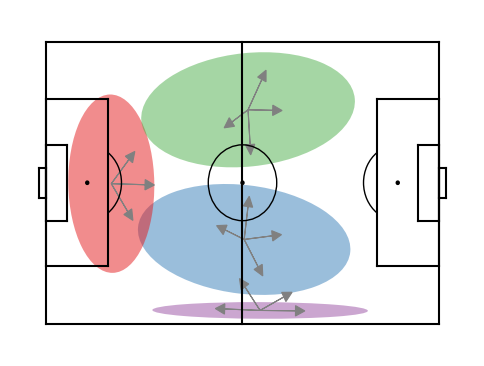

In [19]:
K_loc = 4
K_dir = 4
results = {}

choose = "bregman"
start = time.time()
results[choose] = sc.two_layer_scheme(loc_data, dir_data, K_loc, K_dir, choose=choose)
run_time = time.time() - start

print(f"Running Time {choose} Model: {run_time:.4f}s\n")
# print(f"{results[choose][0]}\n")
# for i, vmm in enumerate(results[choose][1]):
#     print(f"GMM Cluster {i}: ")
#     print(f"{vmm}\n")

gmm, vmm = results["bregman"]
vis.show_all_models(gmm, vmm)

Running Time soccermix Model: 14.3338s



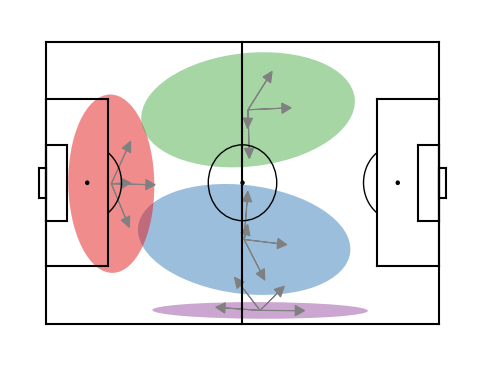

In [20]:
choose = "soccermix"
start = time.time()
results[choose] = sc.two_layer_scheme(loc_data, dir_data, K_loc, K_dir, choose=choose)
run_time = time.time() - start

print(f"Running Time {choose} Model: {run_time:.4f}s\n")
# print(f"{results[choose][0]}\n")
# for i, vmm in enumerate(results[choose][1]):
#     print(f"GMM Cluster {i}: ")
#     print(f"{vmm}\n")

gmm, vmm = results[choose]
vis.show_all_models(gmm, vmm)

Running Time classic Model: 32.0406s



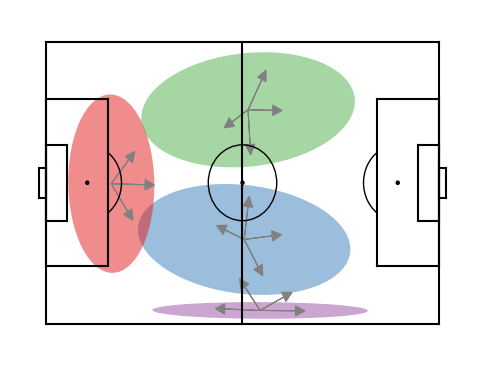

In [21]:
choose = "classic"
start = time.time()
results[choose] = sc.two_layer_scheme(loc_data, dir_data, K_loc, K_dir, choose=choose)
run_time = time.time() - start

print(f"Running Time {choose} Model: {run_time:.4f}s\n")
# print(f"{results[choose][0]}\n")
# for i, vmm in enumerate(results[choose][1]):
#     print(f"GMM Cluster {i}: ")
#     print(f"{vmm}\n")

gmm, vmm = results[choose]
vis.show_all_models(gmm, vmm)

In [24]:
# Collect BIC and AIC results
rows = []
for key, value in results.items():
    loc_model = value[0]
    dir_models = value[1]

    loc_bic = loc_model.bic(loc_data).round(0)
    loc_aic = loc_model.aic(loc_data).round(0)
    rows.append({"Model": key, "Component": "loc_model", "BIC": loc_bic, "AIC": loc_aic})

    for i, vmm in enumerate(dir_models):
        dir_bic = vmm.bic(dir_data).round(0)
        dir_aic = vmm.aic(dir_data).round(0)
        rows.append({"Model": key, "Component": f"dir_model_{i}", "BIC": dir_bic, "AIC": dir_aic})

# Create DataFrame
bic_df = pd.DataFrame(rows)
bic_df.groupby("Model").sum()


,Component,BIC,AIC
Model,,,
bregman,loc_modeldir_model_0dir_model_1dir_model_2dir_model_3,1886975.0,1886555.0
classic,loc_modeldir_model_0dir_model_1dir_model_2dir_model_3,1886973.0,1886552.0
soccermix,loc_modeldir_model_0dir_model_1dir_model_2dir_model_3,1895060.0,1894640.0
